In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_files
from PIL import Image
sns.set_context("talk")
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

PROCESSING IMAGES

In [11]:
labels = ("glioma", "meningioma", "notumor", "pituitary")
img_dim = (512, 512)

In [12]:
import numpy as np
import os
import cv2

def load_images_dataset(label, num_images, kernal_size, img_dim):
    root = os.path.join(os.getcwd(), 'data') # get system path to data folder
    path = os.path.join(root, label) # get path to label folder
    file_paths = os.listdir(path) # list all files

    random_select = np.random.choice(file_paths, num_images, replace=False) # get N random selection of files
    images = []
    for f in random_select:                                         # Preprocess images
        img_path = os.path.join(path, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        ksize = (kernal_size, kernal_size)
        img = cv2.resize(img, img_dim, interpolation=cv2.INTER_LINEAR)
        blur = cv2.blur(img, ksize)
        normalized_img = cv2.normalize(blur, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        images.append(normalized_img)

    return images

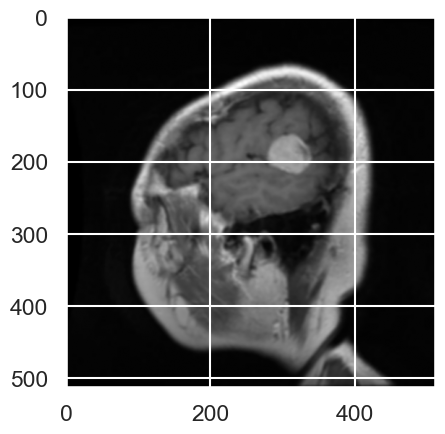

In [13]:
images = load_images_dataset('glioma', 200, 5, img_dim)
plt.imshow(images[1], cmap='gray')

In [14]:
def convert_images_to_np_array(img_list):
    size = len(img_list)

    for i in range(size):
        num_col = img_list[i].shape[0] * img_list[i].shape[1] # 512 x 512
        img_list[i] =  np.ndarray.flatten(img_list[i]).reshape(num_col, 1)

    img_stack = np.dstack(img_list)
    img_stack = np.rollaxis(img_stack, axis = 2, start = 0)
    img_stack = img_stack.reshape(size, num_col)

    return img_stack


In [18]:
def create_dataframe(num_images, kernal_size, img_dim):

    df_list = []

    for l in labels:
        temp_list = load_images_dataset(l, num_images, kernal_size, img_dim)
        temp_array = convert_images_to_np_array(temp_list)
        temp_df = pd.DataFrame(temp_array)
        temp_df['label'] = l
        df_list.append(temp_df)

    act = pd.concat(df_list, ignore_index=True)

    return act

https://www.geeksforgeeks.org/machine-learning/multi-label-image-classification-prediction-of-image-labels/

In [20]:
df = create_dataframe(num_images=200, kernal_size=5, img_dim=img_dim)
print(df.shape)
df.head()
df.tail()

(800, 262145)


,0,1,2,3,4,5,6,7,8,9,...,262135,262136,262137,262138,262139,262140,262141,262142,262143,label
795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pituitary
796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pituitary
797,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,pituitary
798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pituitary
799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pituitary


SUPERVISED LEARNING MODEL

UNSUPERVISED LEARNING MODEL

In [8]:
def kmeans(X, k, max_iter=10, rand_seed=0):
    np.random.seed(rand_seed)
    Mu = X[np.random.choice(X.shape[0],k),:]    
    for i in range(max_iter):
        D = -2*X@Mu.T + (X**2).sum(axis=1)[:,None] + (Mu**2).sum(axis=1)   
        y = np.argmin(D,axis=1)
        Mu = np.array([np.mean(X[y==i],axis=0) for i in range(k)])         
    loss = np.linalg.norm(X - Mu[np.argmin(D,axis=1),:])**2/X.shape[0]   
    return Mu, y, loss